## 0. Imports

In [1]:
from pathlib import Path
from urllib.request import urlretrieve
import warnings

import numpy as np
from obspy import UTCDateTime
from waveform_collection import gather_waveforms

from rtm import (calculate_time_buffer, define_grid, get_peak_coordinates,
                 grid_search, plot_record_section, plot_st, plot_time_slice,
                 process_waveforms, produce_dem)

# Ignore benign Matplotlib backend warning due to fig.show()
warnings.filterwarnings(action='ignore', category=UserWarning, message='FigureCanvasAgg is non-interactive')

/Users/ltoney/repos/rtm/rtm/plotting.py:20: SyntaxWarning: invalid escape sequence '\m'
  """


## 1. Define grid

To obtain `DEM_WGS84.tif` from OpenTopography (~200 MB GeoTIFF) and resample to `DEM_WGS84_resampled.tif`, run:

In [2]:
DEM_URL = 'https://opentopography.s3.sdsc.edu/dataspace/OTDS.072019.4326.1/raster/DEM_WGS84.tif'
dem_file = 'DEM_WGS84_resampled.tif'
RES = 0.00005  # [deg.]
if not Path(dem_file).is_file():
    print('Downloading and resampling DEM...')
    !gdalwarp -tr {RES} {RES} -r cubicspline {urlretrieve(DEM_URL)[0]} {dem_file}
    print('Done')

Creating output file that is 253P x 260L.
Using internal nodata values (e.g. 0) for image /var/folders/kt/r_9qxn7d6wgc0lwylt3t3qx8bb196z/T/tmpeuuapu_v.
Copying nodata values from source /var/folders/kt/r_9qxn7d6wgc0lwylt3t3qx8bb196z/T/tmpeuuapu_v to destination DEM_WGS84_resampled.tif.
Processing /var/folders/kt/r_9qxn7d6wgc0lwylt3t3qx8bb196z/T/tmpeuuapu_v [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Done


Alternatively, specify `DEM_FILE = None` below to automatically download and use 1 arc-second SRTM data.

In [3]:
DEM_FILE = dem_file

LON_0 = 169.448212  # [deg] Longitude of grid center
LAT_0 = -19.527908  # [deg] Latitude of grid center

X_RADIUS = 600  # [m] E-W grid radius (half of grid "width")
Y_RADIUS = 650  # [m] N-S grid radius (half of grid "height")
SPACING = 2  # [m] Grid spacing

grid = define_grid(
    lon_0=LON_0,
    lat_0=LAT_0,
    x_radius=X_RADIUS,
    y_radius=Y_RADIUS,
    spacing=SPACING,
    projected=True,
)

-------------
DEFINING GRID
-------------
Done


## 2. Grab and process the data

In [4]:
# Start and end of time window containing (suspected) events
STARTTIME = UTCDateTime('2016-07-30T05:22:45')
ENDTIME = STARTTIME + 10

# Data collection parameters
SOURCE = 'IRIS'
NETWORK = '3E'
STATION = 'YIF?'
LOCATION = '*'
CHANNEL = '*'

MAX_STATION_DIST = 0.8  # [km] Max. dist. from grid center to station (approx.)

FREQ_MIN = 0.5  # [Hz] Lower bandpass corner
FREQ_MAX = 10  # [Hz] Upper bandpass corner

DECIMATION_RATE = 20  # [Hz] New sampling rate to use for decimation
SMOOTH_WIN = 0.5  # [s] Smoothing window duration

# Automatically determine appropriate time buffer in s
time_buffer = calculate_time_buffer(grid, MAX_STATION_DIST)

st = gather_waveforms(
    source=SOURCE,
    network=NETWORK,
    station=STATION,
    location=LOCATION,
    channel=CHANNEL,
    starttime=STARTTIME,
    endtime=ENDTIME,
    time_buffer=time_buffer,
)

for tr in st.select(station='YIF6'):
    st.remove(tr)  # Otherwise infresnel fails since this station is outside the DEM file extent!

st_proc = process_waveforms(
    st,
    freqmin=FREQ_MIN,
    freqmax=FREQ_MAX,
    envelope=True,
    smooth_win=SMOOTH_WIN,
    decimation_rate=DECIMATION_RATE,
    normalize=True,
)

--------------
GATHERING DATA
--------------
Reading data from IRIS FDSN...


6 Trace(s) in Stream:
3E.YIF1.01.CDF | 2016-07-30T05:22:45.000000Z - 2016-07-30T05:23:02.655000Z | 400.0 Hz, 7063 samples
3E.YIF2.01.CDF | 2016-07-30T05:22:45.000000Z - 2016-07-30T05:23:02.655000Z | 400.0 Hz, 7063 samples
3E.YIF3.01.CDF | 2016-07-30T05:22:45.000000Z - 2016-07-30T05:23:02.655000Z | 400.0 Hz, 7063 samples
3E.YIF4.01.CDF | 2016-07-30T05:22:45.000000Z - 2016-07-30T05:23:02.655000Z | 400.0 Hz, 7063 samples
3E.YIF5.01.CDF | 2016-07-30T05:22:45.000000Z - 2016-07-30T05:23:02.655000Z | 400.0 Hz, 7063 samples
3E.YIF6.01.CDF | 2016-07-30T05:22:45.000000Z - 2016-07-30T05:23:02.655000Z | 400.0 Hz, 7063 samples
Assigning coordinates...
Done
---------------
PROCESSING DATA
---------------
Detrending...
Tapering...
Filtering...
Enveloping...
Decimating...
Smoothing...
Normalizing...
Done


## 3. Perform grid search

In [5]:
STACK_METHOD = 'sum'  # Choose either 'sum', 'product', or 'semblance'
TIME_METHOD = 'infresnel'  # Choose either 'celerity' or 'fdtd' or 'infresnel'
TIME_KWARGS = {
    'celerity': 343,
    'dem_file': DEM_FILE, 
    'stored_result': 'diff_path_lens.nc',
    'n_jobs': -2,
}

S = grid_search(
    processed_st=st_proc,
    grid=grid,
    time_method=TIME_METHOD,
    starttime=STARTTIME,
    endtime=ENDTIME,
    stack_method=STACK_METHOD,
    **TIME_KWARGS
)

/Users/ltoney/repos/rtm/rtm/travel_time.py:409: UserWarning: 52.3% of DEM is NaN!
  _diff_path_lens = calculate_paths(


----------------------------------------------------------------
CALCULATING TRAVEL TIMES USING INFRESNEL WITH CELERITY = 343 M/S
----------------------------------------------------------------

(1/5) Station 3E.YIF1.01.CDF

Loading and projecting DEM...
Done

DEM spacing = 5.40 m -> profile spacing = 2.70 m

Checking that DEM contains source and receivers...
Done — 168594 invalid paths will be set to NaN

Fitting spline to DEM...
Done

Computing 391251 paths...


  0% |          | 0/391251 paths 

/Users/ltoney/repos/rtm/rtm/travel_time.py:409: UserWarning: 52.3% of DEM is NaN!
  _diff_path_lens = calculate_paths(


Done

(2/5) Station 3E.YIF2.01.CDF

Loading and projecting DEM...
Done

DEM spacing = 5.40 m -> profile spacing = 2.70 m

Checking that DEM contains source and receivers...
Done — 168594 invalid paths will be set to NaN

Fitting spline to DEM...
Done

Computing 391251 paths...


  0% |          | 0/391251 paths 

/Users/ltoney/repos/rtm/rtm/travel_time.py:409: UserWarning: 52.3% of DEM is NaN!
  _diff_path_lens = calculate_paths(


Done

(3/5) Station 3E.YIF3.01.CDF

Loading and projecting DEM...
Done

DEM spacing = 5.40 m -> profile spacing = 2.70 m

Checking that DEM contains source and receivers...
Done — 168594 invalid paths will be set to NaN

Fitting spline to DEM...
Done

Computing 391251 paths...


  0% |          | 0/391251 paths 

/Users/ltoney/repos/rtm/rtm/travel_time.py:409: UserWarning: 52.3% of DEM is NaN!
  _diff_path_lens = calculate_paths(


Done

(4/5) Station 3E.YIF4.01.CDF

Loading and projecting DEM...
Done

DEM spacing = 5.40 m -> profile spacing = 2.70 m

Checking that DEM contains source and receivers...
Done — 168594 invalid paths will be set to NaN

Fitting spline to DEM...
Done

Computing 391251 paths...


  0% |          | 0/391251 paths 

/Users/ltoney/repos/rtm/rtm/travel_time.py:409: UserWarning: 52.3% of DEM is NaN!
  _diff_path_lens = calculate_paths(


Done

(5/5) Station 3E.YIF5.01.CDF

Loading and projecting DEM...
Done

DEM spacing = 5.40 m -> profile spacing = 2.70 m

Checking that DEM contains source and receivers...
Done — 168594 invalid paths will be set to NaN

Fitting spline to DEM...
Done

Computing 391251 paths...


  0% |          | 0/391251 paths 

/Users/ltoney/repos/rtm/rtm/grid.py:480: RuntimeWarning: invalid value encountered in cast
  st[0].stats.sampling_rate).astype(int)


Done
Done (elapsed time = 106 s)
Diffracted path lengths saved to diff_path_lens.nc
----------------------
PERFORMING GRID SEARCH
Method = 'sum'
----------------------


100% |██████████████████████████████████████████████| 391251/391251 grid points 

Done (elapsed time = 28.6 s)


## 4. Plot

Applying sensitivity
Filtering between 0.5-10.0 Hz
--------------
PROCESSING DEM
--------------
Using external DEM file:
	/Users/ltoney/repos/rtm/DEM_WGS84_resampled.tif
Done
Returning just global max!


Unprojecting coordinates from UTM to (latitude, longitude).
Converting to x/y grid, cropping 600 m from center


Found 1 peaks in stack for height > 3.0 and min_time > 2.0 s.
Unprojecting coordinates from UTM to (latitude, longitude).


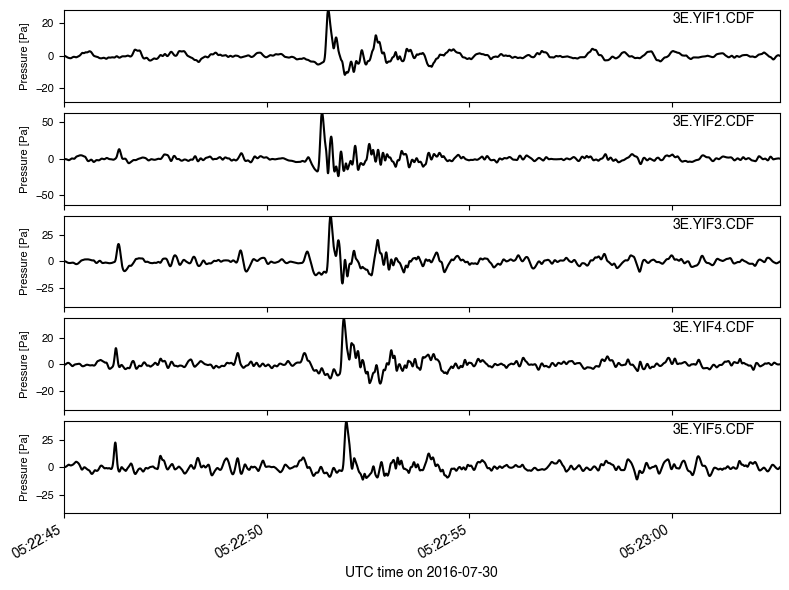

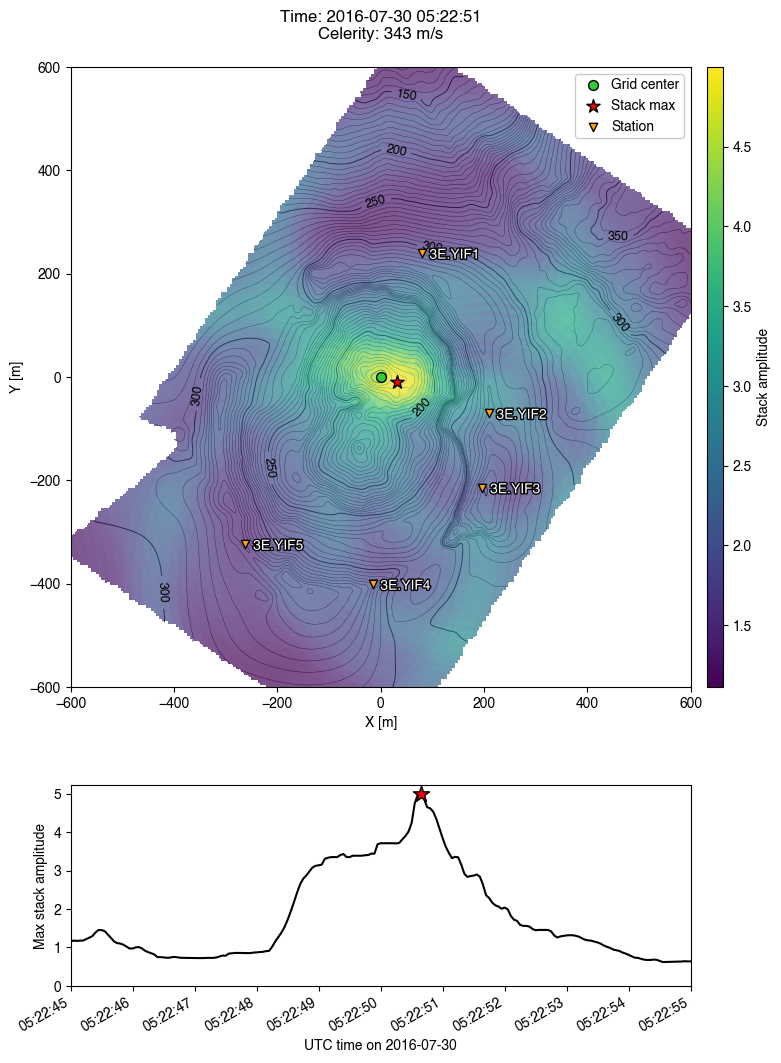

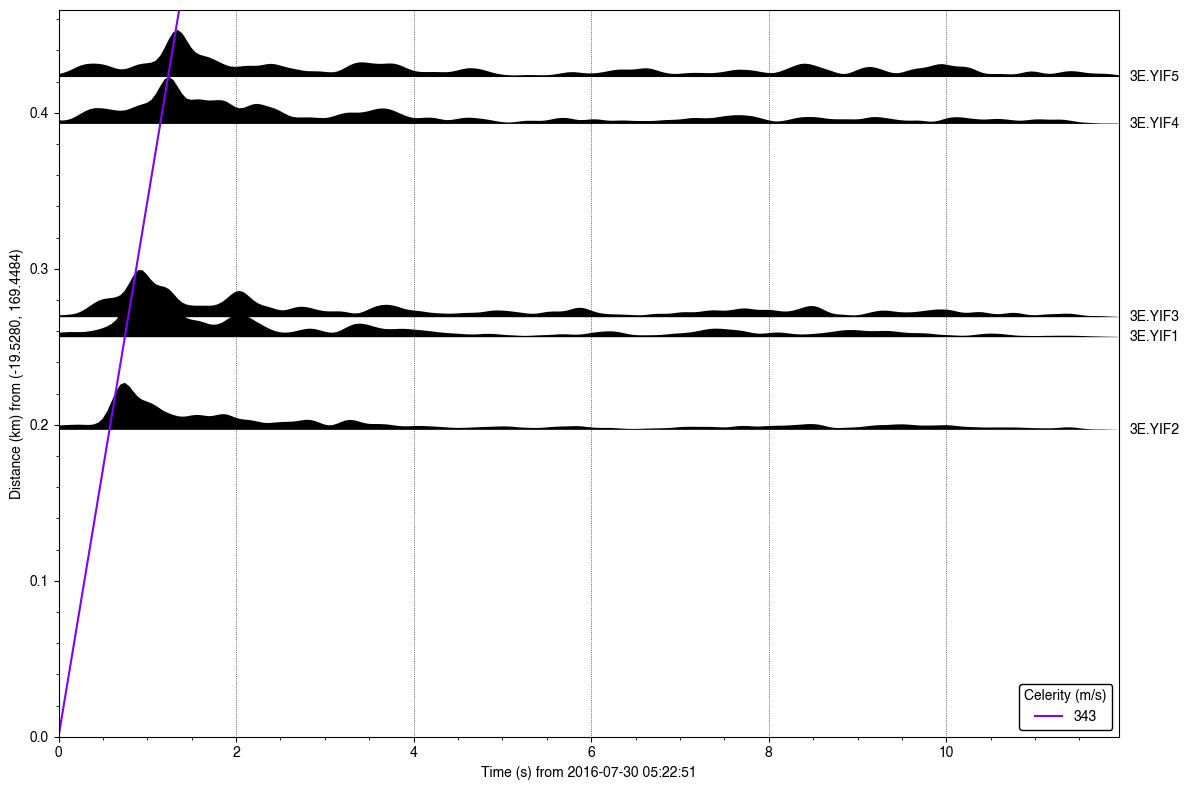

In [6]:
fig_st = plot_st(
    st,
    filt=[FREQ_MIN, FREQ_MAX],
    equal_scale=False,
    remove_response=True,
    label_waveforms=True,
)

dem_backdrop = produce_dem(grid, external_file=DEM_FILE, plot_output=False)
fig_slice = plot_time_slice(
    S, st_proc, label_stations=True, dem=dem_backdrop, plot_peak=True, xy_grid=600
)

time_max, y_max, x_max, peaks, props = get_peak_coordinates(
    S, global_max=False, height=3, min_time=2, unproject=S.UTM
)

peak_ind = np.argmax(props['peak_heights'])

fig = plot_record_section(
    st_proc,
    origin_time=time_max[peak_ind],
    source_location=(y_max[peak_ind], x_max[peak_ind]),
    plot_celerity=S.celerity,
    label_waveforms=True,
)